# ✅ Projeto IA - Regressão e Classificação com o Dataset Air Quality (UCI)


In [ ]:
# Instalação (caso esteja no Colab)
!pip install xgboost openpyxl

In [58]:
# 📦 1. Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import zipfile

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

from imblearn.over_sampling import SMOTE

# 📥 2. Carregamento e Limpeza dos Dados


In [59]:
# Link direto do zip com os dados
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"

# Faz download do zip em memória
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Carrega o arquivo CSV que está dentro do zip
with zip_file.open('AirQualityUCI.csv') as file:
    df = pd.read_csv(file, sep=';', decimal=',')

# Mostra as 5 primeiras linhas para verificar
display(df.head())


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [60]:
# Remover as duas últimas colunas
df = df.iloc[:, :-2]

# Opcional: verificar as colunas restantes
df.columns

# O objetivo é tratar valores negativos que não sejam o -200 já tratado.
print("Limpando valores negativos dos sensores...")
# Identificar todas as colunas que são de sensores, EXCLUINDO 'Date' e 'Time'
sensor_columns = [col for col in df.columns if col not in ['Date', 'Time']]

# Para cada coluna de sensor, substituir qualquer valor < 0 por NaN (Not a Number)
# Isso garante que erros de medição negativos sejam tratados como dados ausentes.
df[sensor_columns] = df[sensor_columns].mask(df[sensor_columns] < 0, np.nan)

# Preencher valores ausentes usando interpolação linear
# Esta é uma boa abordagem para dados de série temporal
df.interpolate(method='linear', inplace=True)

# Remover qualquer linha que ainda possa ter NaN (geralmente no início do arquivo)
df.dropna(inplace=True)

print("Dados carregados e limpos com sucesso!")

# Converter colunas de Data e Hora para um único índice de Datetime
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), format='%d/%m/%Y %H.%M.%S')
df = df.set_index('DateTime')

print("\nTipos de dados:")
print(df.info())

df = df.drop(['Date', 'Time'], axis=1)

df.head()

Limpando valores negativos dos sensores...
Dados carregados e limpos com sucesso!

Tipos de dados:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: fl

/tmp/ipython-input-60-560570252.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


# 📊 3. Análise Exploratória (EDA)

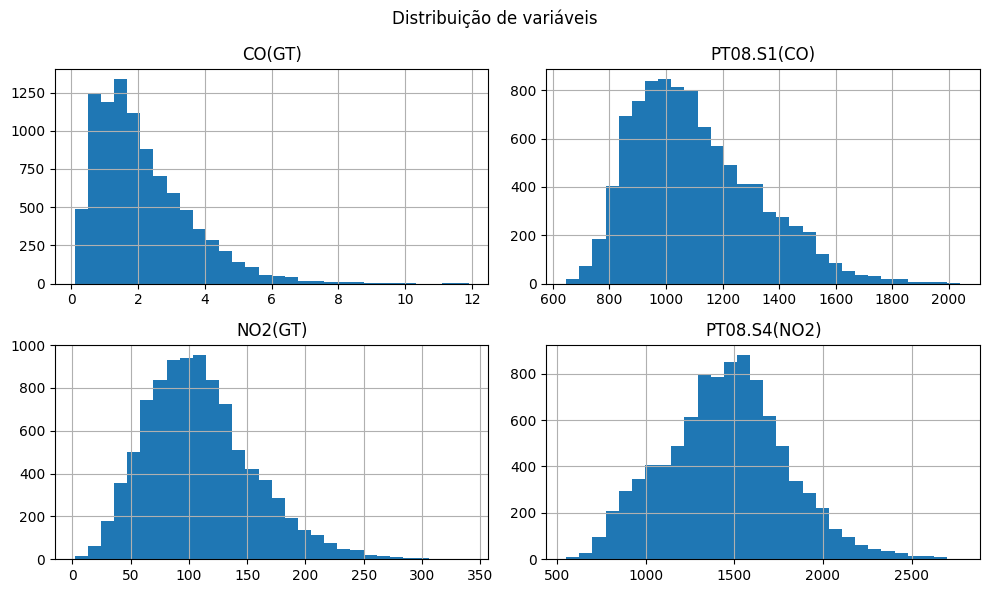

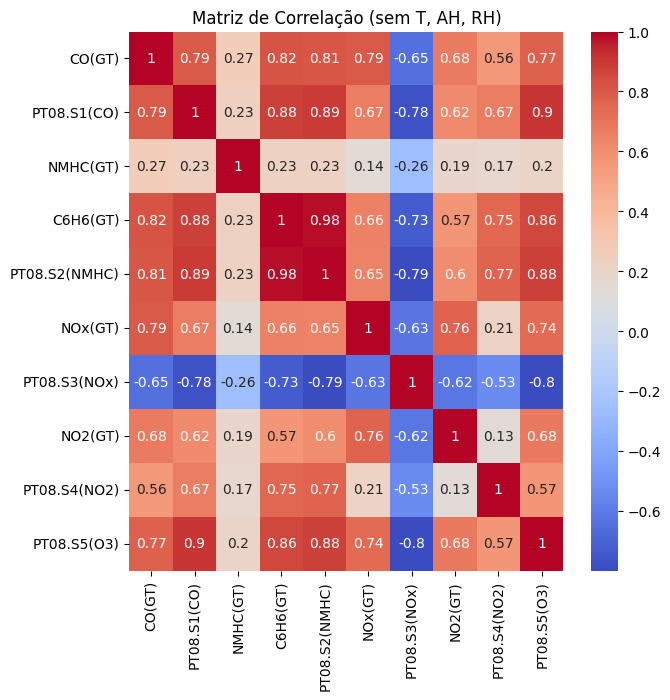

In [61]:
# Histograma das principais variáveis
df[['CO(GT)', 'PT08.S1(CO)', 'NO2(GT)', 'PT08.S4(NO2)']].hist(bins=30, figsize=(10, 6))
plt.suptitle("Distribuição de variáveis")
plt.tight_layout()

# Matriz de correlação (removendo T, AH, RH para esta visualização)
df_corr_subset = df.drop(columns=['T', 'AH', 'RH'])
plt.figure(figsize=(7, 7))
sns.heatmap(df_corr_subset.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação (sem T, AH, RH)")
plt.show()

# 📚 4. Classificação — Categorias de Concentração de CO

Distribuição original das classes:
CO_Class
0    8384
1     968
2       5
Name: count, dtype: int64

Distribuição após SMOTE:
CO_Class
0    8384
1    8384
2    8384
Name: count, dtype: int64

🔧 Ajuste de Hiperparâmetros para CLASSIFICAÇÃO (GridSearchCV)

Procurando melhores parâmetros para: Logistic Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Melhores parâmetros para Logistic Regression: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Melhor score CV (accuracy): 0.9503

Procurando melhores parâmetros para: Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor score CV (accuracy): 0.9834

Procurando melhores parâmetros para: XGBoost
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsam

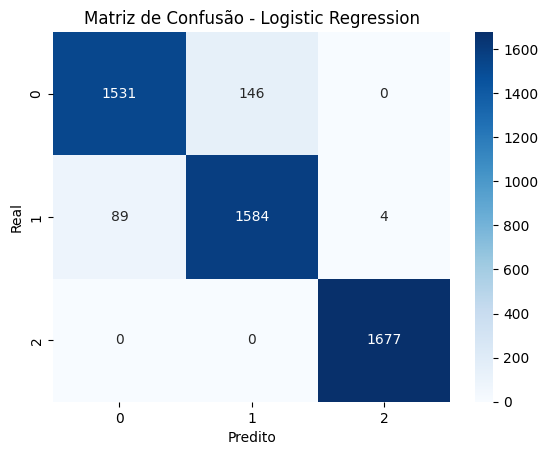


🔹 Random Forest (Tuned)
Acurácia: 0.9841
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1677
           1       0.96      0.99      0.98      1677
           2       1.00      1.00      1.00      1677

    accuracy                           0.98      5031
   macro avg       0.98      0.98      0.98      5031
weighted avg       0.98      0.98      0.98      5031



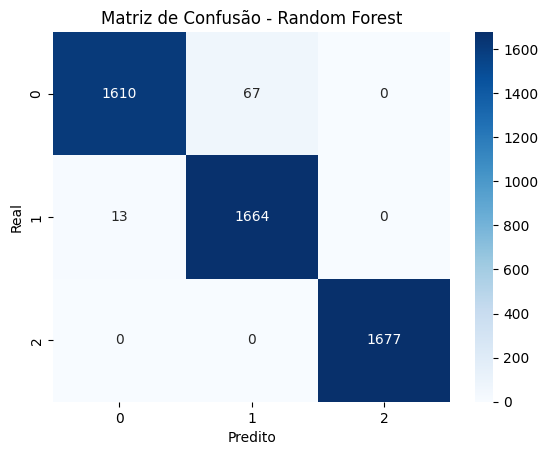


🔹 XGBoost (Tuned)
Acurácia: 0.9781
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1677
           1       0.96      0.98      0.97      1677
           2       1.00      1.00      1.00      1677

    accuracy                           0.98      5031
   macro avg       0.98      0.98      0.98      5031
weighted avg       0.98      0.98      0.98      5031



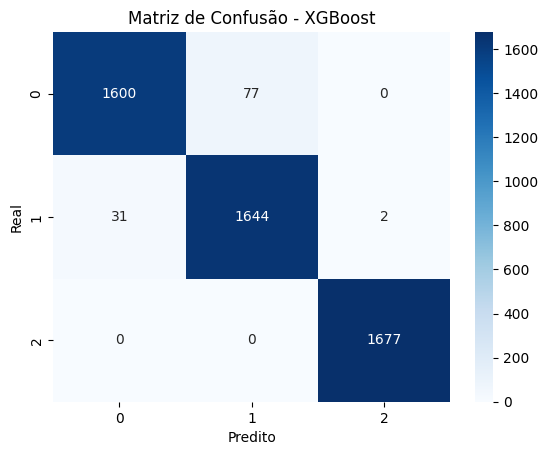

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")  # Opcional, para limpar avisos do XGBoost

# 1. Criar categorias para classificação
def classificar_co(valor):
    if valor <= 4.0:
        return 0  # baixa
    elif valor <= 10.0:
        return 1  # média
    else:
        return 2  # alta

df['CO_Class'] = df['CO(GT)'].apply(classificar_co)

print("Distribuição original das classes:")
print(df['CO_Class'].value_counts())

# 2. Separar X e y
X = df.drop(columns=['CO(GT)', 'CO_Class', 'datetime'], errors='ignore')
y = df['CO_Class']

# 3. Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("\nDistribuição após SMOTE:")
print(pd.Series(y_resampled).value_counts())

# 5. Dividir conjunto balanceado
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# 6. Modelos
models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# 7. Hiperparâmetros
param_grid_clf = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [1000]
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1]
    }
}

# 8. Ajuste com GridSearchCV
print("\n🔧 Ajuste de Hiperparâmetros para CLASSIFICAÇÃO (GridSearchCV)")
best_models_clf = {}

for name, model in models_clf.items():
    print(f"\nProcurando melhores parâmetros para: {name}")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid_clf[name],
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_models_clf[name] = grid_search.best_estimator_

    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")
    print(f"Melhor score CV (accuracy): {grid_search.best_score_:.4f}")

# 9. Avaliação dos modelos ajustados
print("\n📘 Avaliação dos modelos AJUSTADOS para CLASSIFICAÇÃO")

for name, model in best_models_clf.items():
    y_pred = model.predict(X_test)

    print(f"\n🔹 {name} (Tuned)")
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()


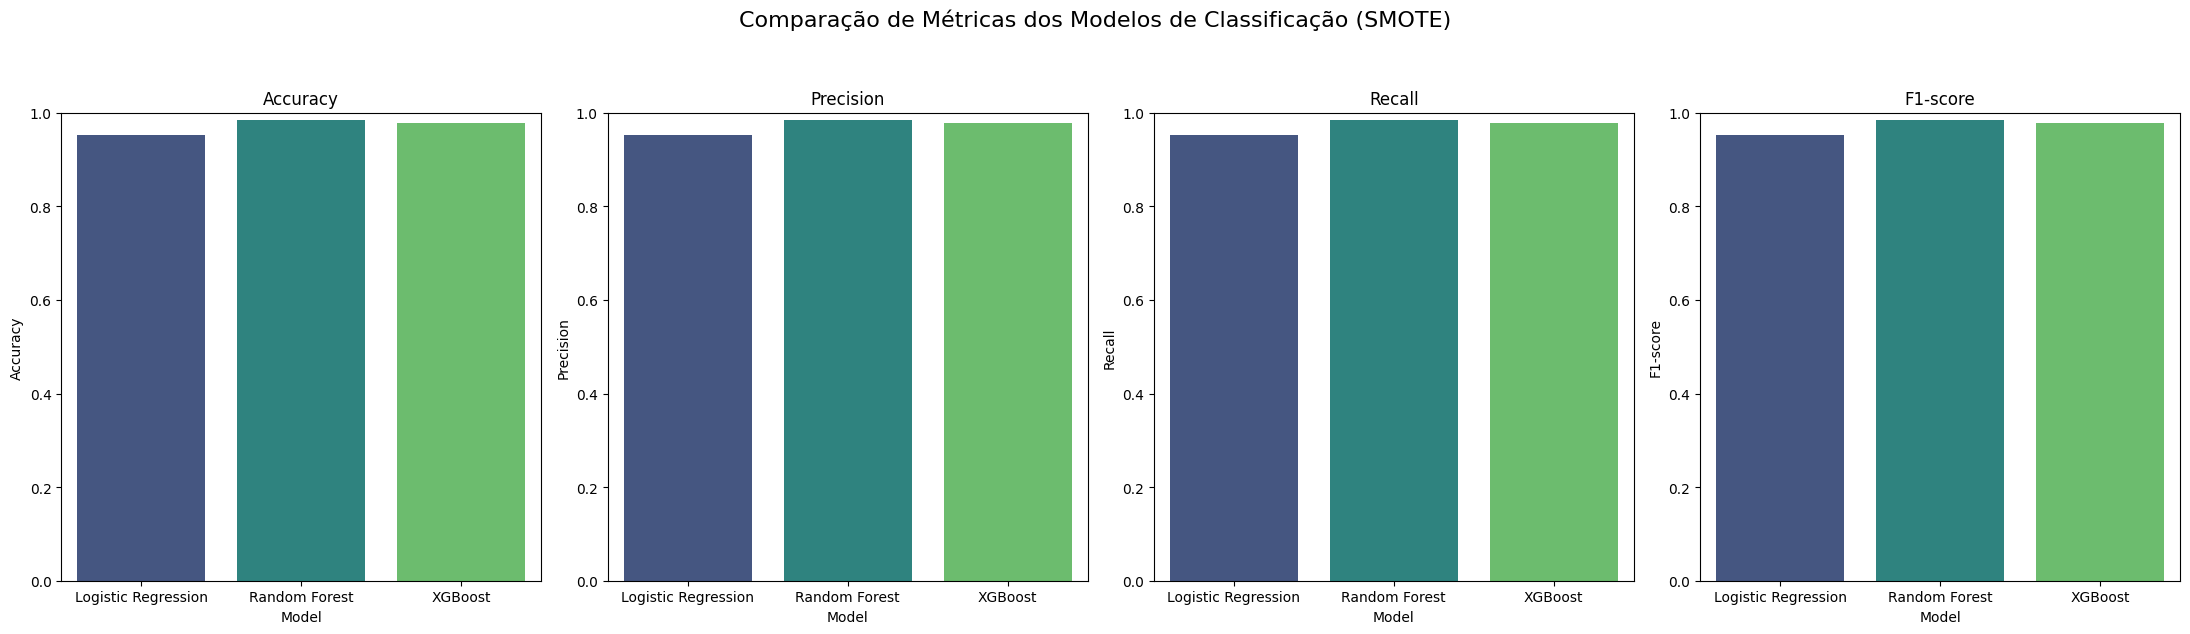

In [69]:
# Criar DataFrame para armazenar métricas
metrics_list = []

# Novo loop para armazenar métricas
# Iterate through the best_models_clf dictionary instead of models_clf
for name, model in best_models_clf.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Adiciona métricas macro
    metrics_list.append({'Model': name, 'Metric': 'Accuracy', 'Score': accuracy})
    metrics_list.append({'Model': name, 'Metric': 'Precision', 'Score': report['macro avg']['precision']})
    metrics_list.append({'Model': name, 'Metric': 'Recall', 'Score': report['macro avg']['recall']})
    metrics_list.append({'Model': name, 'Metric': 'F1-score', 'Score': report['macro avg']['f1-score']})

# Criar DataFrame
metrics_df = pd.DataFrame(metrics_list)
# Criar gráficos de barras lado a lado
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score']

fig, axes = plt.subplots(1, 4, figsize=(22, 6))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(
        x='Model',
        y='Score',
        data=metrics_df[metrics_df['Metric'] == metric],
        ax=axes[i],
        palette='viridis'
    )
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1.0)
    axes[i].tick_params(axis='x', rotation=0)

plt.suptitle("Comparação de Métricas dos Modelos de Classificação (SMOTE)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#📉 5. Classificação com PCA


📘 CLASSIFICAÇÃO com PCA (Random Forest)
Acurácia: 0.979129397734049
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1677
           1       0.95      0.98      0.97      1677
           2       1.00      1.00      1.00      1677

    accuracy                           0.98      5031
   macro avg       0.98      0.98      0.98      5031
weighted avg       0.98      0.98      0.98      5031



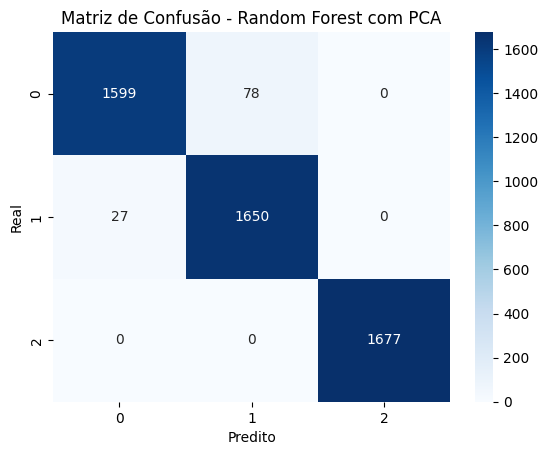

🔍 PCA manteve 4 componentes principais (explicando 95.58% da variância).


In [70]:
from sklearn.decomposition import PCA
best_model_name = 'Random Forest'  # troque pelo nome do melhor modelo encontrado
best_model = best_models_clf[best_model_name]

# PCA que mantém >95% da variância
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Treinar o melhor modelo nos dados transformados pelo PCA
best_model.fit(X_train_pca, y_train)

# Predição e avaliação
y_pred_pca = best_model.predict(X_test_pca)

print(f"\n📘 CLASSIFICAÇÃO com PCA ({best_model_name})")
print("Acurácia:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))

# Matriz de Confusão
cm_pca = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {best_model_name} com PCA')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Informar número de componentes mantidos
print(f"🔍 PCA manteve {pca.n_components_} componentes principais "
      f"(explicando {sum(pca.explained_variance_ratio_)*100:.2f}% da variância).")

# 🎯 6. Regressão - Concentração de CO

In [71]:
# 1. Variáveis de entrada e saída
X_reg = df.drop(columns=['CO(GT)', 'datetime'], errors='ignore')
y_reg = df['CO(GT)']

# 2. Escalonamento
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)

# 3. Divisão treino/teste
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg_scaled, y_reg, test_size=0.2, random_state=42
)

# 4. Modelos de regressão
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}


# --- Ajuste de hiperparâmetros para modelos de REGRESSÃO ---

param_grid_reg = {
    'Linear Regression': {
        'fit_intercept': [True, False]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [1]
    }
}

print("\n🔧 Ajuste de Hiperparâmetros para REGRESSÃO (GridSearchCV)")

best_models_reg = {}

for name, model in models_reg.items():
    print(f"\nProcurando melhores parâmetros para: {name}")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid_reg[name],
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(Xr_train, yr_train)
    best_models_reg[name] = grid_search.best_estimator_

    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")
    print(f"Melhor score CV (R²): {grid_search.best_score_:.4f}")

# Avaliar modelos ajustados
print("\n📘 Avaliação dos modelos ajustados para REGRESSÃO")
for name, model in best_models_reg.items():
    y_pred = model.predict(Xr_test)
    r2 = r2_score(yr_test, y_pred)
    rmse = np.sqrt(mean_squared_error(yr_test, y_pred))
    mae = mean_absolute_error(yr_test, y_pred)

    print(f"\n🔹 {name} (tuned)")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# 5. Treinamento e avaliação
print("📘 REGRESSÃO")
for name, model in models_reg.items():
    model.fit(Xr_train, yr_train)
    y_pred = model.predict(Xr_test)

    r2 = r2_score(yr_test, y_pred)
    rmse = np.sqrt(mean_squared_error(yr_test, y_pred))
    mae = mean_absolute_error(yr_test, y_pred)

    print(f"\n🔹 {name}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")


🔧 Ajuste de Hiperparâmetros para REGRESSÃO (GridSearchCV)

Procurando melhores parâmetros para: Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Melhores parâmetros para Linear Regression: {'fit_intercept': True}
Melhor score CV (R²): 0.8512

Procurando melhores parâmetros para: Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Melhor score CV (R²): 0.9108

Procurando melhores parâmetros para: XGBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1}
Melhor score CV (R²): 0.9037

📘 Avaliação dos modelos ajustados para REGRESSÃO

🔹 Linear Regression (tuned)
R²: 0.8687
RMSE: 0.5349
MAE: 0.3716

🔹 Random Forest (tuned)
R²: 0.9178
RMSE: 0.4233
MAE: 0.2675

🔹 XGBoost (tuned)
R²: 0.9108
RMSE: 

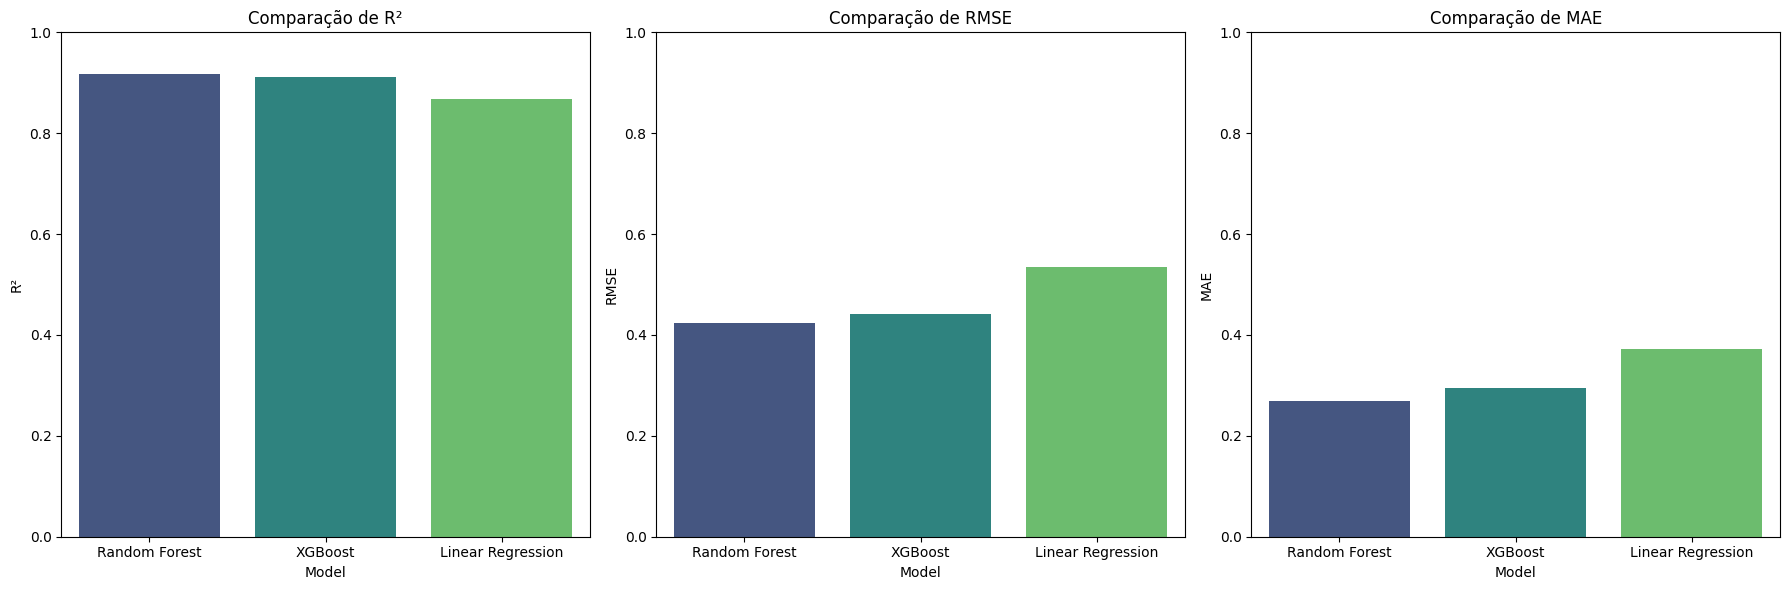

In [72]:
# Coletar métricas
results = {
    'Model': [],
    'R2': [],
    'RMSE': [],
    'MAE': []
}

for name, model in models_reg.items():
    y_pred = model.predict(Xr_test)
    results['Model'].append(name)
    results['R2'].append(r2_score(yr_test, y_pred))
    results['RMSE'].append(np.sqrt(mean_squared_error(yr_test, y_pred)))
    results['MAE'].append(mean_absolute_error(yr_test, y_pred))

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2', ascending=False) # Ordenar por R2 para melhor visualização

# Gráficos de barra
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='Model', y='R2', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_title('Comparação de R²')
axes[0].set_ylabel('R²')
axes[0].set_ylim(0, 1.0) # Ajustar limite para melhor visualização das diferenças

sns.barplot(x='Model', y='RMSE', data=results_df, ax=axes[1], palette='viridis')
axes[1].set_title('Comparação de RMSE')
axes[1].set_ylabel('RMSE')
axes[1].set_ylim(0, 1.0) # Ajustar limite

sns.barplot(x='Model', y='MAE', data=results_df, ax=axes[2], palette='viridis')
axes[2].set_title('Comparação de MAE')
axes[2].set_ylabel('MAE')
axes[2].set_ylim(0, 1.0) # Ajustar limite

plt.tight_layout()
plt.show()

# 🔻 7. Aplicando PCA


📘 REGRESSÃO com PCA
R²: 0.9131
RMSE: 0.4352
MAE: 0.2783


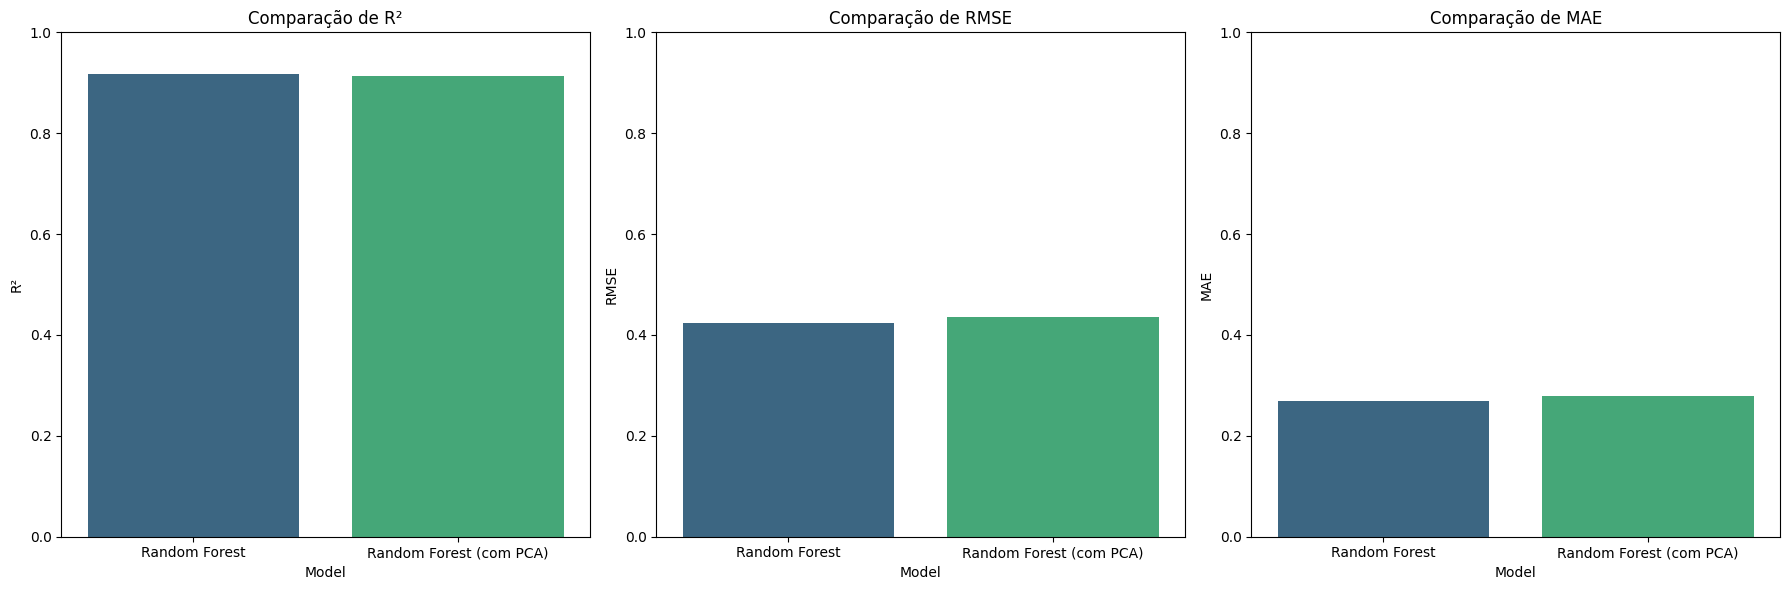

In [73]:
best_model_name = 'Random Forest'  # troque pelo nome do melhor modelo encontrado
best_model = best_models_reg[best_model_name]

# Aplicar PCA
pca = PCA()
Xr_train_pca = pca.fit_transform(Xr_train)
Xr_test_pca = pca.transform(Xr_test)

# Usar melhor modelo (Random Forest)
best_model.fit(Xr_train_pca, yr_train)

# Predição com PCA
y_pred_pca = best_model.predict(Xr_test_pca)

print("\n📘 REGRESSÃO com PCA")
print(f"R²: {r2_score(yr_test, y_pred_pca):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(yr_test, y_pred_pca)):.4f}")
print(f"MAE: {mean_absolute_error(yr_test, y_pred_pca):.4f}")

# Coletar métricas para Random Forest sem PCA (assuming results_df from models_reg is available)
rf_no_pca_results = results_df[results_df['Model'] == 'Random Forest'].iloc[0]

# Collect metrics for Random Forest with PCA
rf_pca_results = {
    'Model': 'Random Forest (com PCA)',
    'R2': r2_score(yr_test, y_pred_pca),
    'RMSE': np.sqrt(mean_squared_error(yr_test, y_pred_pca)),
    'MAE': mean_absolute_error(yr_test, y_pred_pca)
}

# Combine the results into a single DataFrame for plotting
comparison_data = {
    'Model': [rf_no_pca_results['Model'], rf_pca_results['Model']],
    'R2': [rf_no_pca_results['R2'], rf_pca_results['R2']],
    'RMSE': [rf_no_pca_results['RMSE'], rf_pca_results['RMSE']],
    'MAE': [rf_no_pca_results['MAE'], rf_pca_results['MAE']]
}
comparison_df = pd.DataFrame(comparison_data)

# Reshape the DataFrame for plotting with Seaborn
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create bar charts for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='Model', y='Score', data=comparison_melted[comparison_melted['Metric'] == 'R2'], ax=axes[0], palette='viridis')
axes[0].set_title('Comparação de R²')
axes[0].set_ylabel('R²')
axes[0].set_ylim(0, 1.0) # Adjust limit

sns.barplot(x='Model', y='Score', data=comparison_melted[comparison_melted['Metric'] == 'RMSE'], ax=axes[1], palette='viridis')
axes[1].set_title('Comparação de RMSE')
axes[1].set_ylabel('RMSE')
axes[1].set_ylim(0, 1.0) # Adjust limit

sns.barplot(x='Model', y='Score', data=comparison_melted[comparison_melted['Metric'] == 'MAE'], ax=axes[2], palette='viridis')
axes[2].set_title('Comparação de MAE')
axes[2].set_ylabel('MAE')
axes[2].set_ylim(0, 1.0) # Adjust limit

plt.tight_layout()
plt.show()

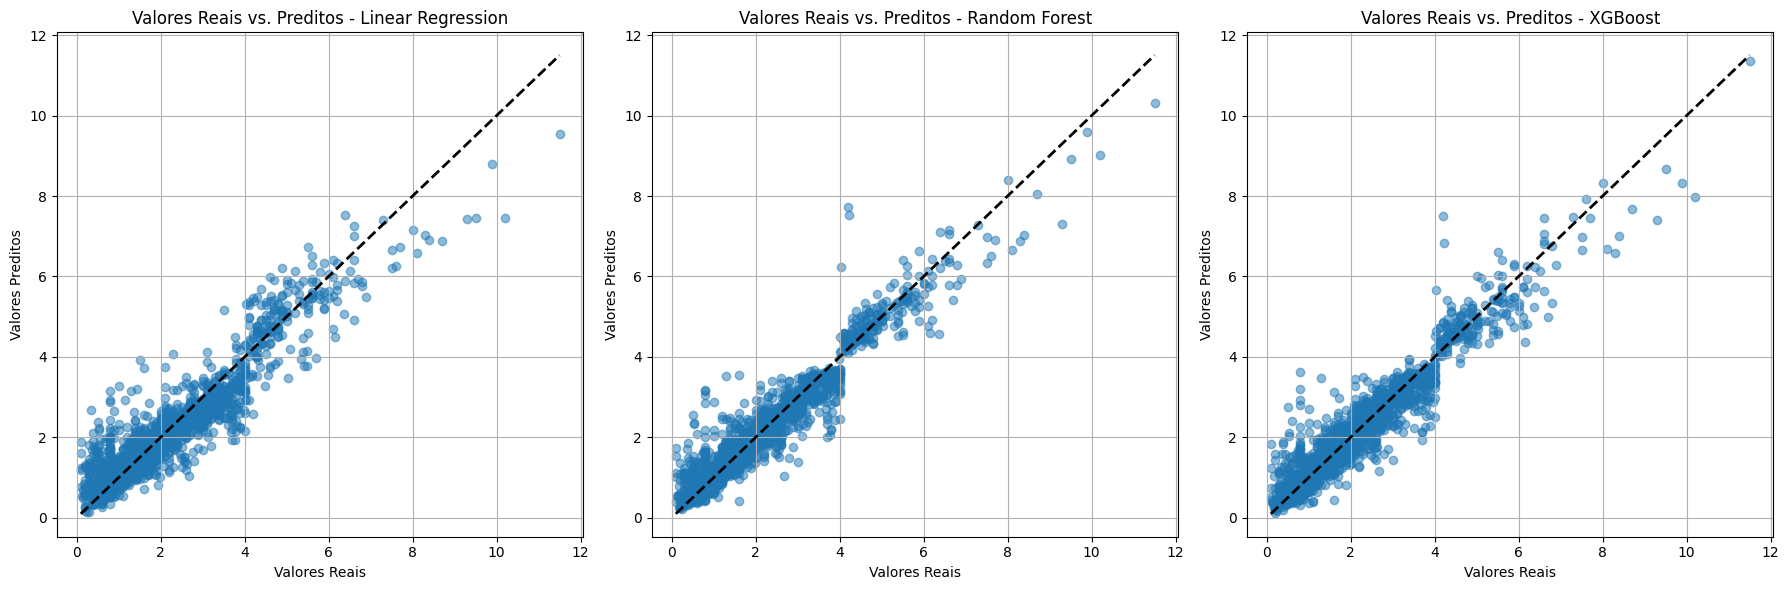

In [74]:
# Visualizar resultados da regressão
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Create a 1x3 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (name, model) in enumerate(models_reg.items()):
    y_pred = model.predict(Xr_test)

    axes[i].scatter(yr_test, y_pred, alpha=0.5)
    axes[i].plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'k--', lw=2)
    axes[i].set_xlabel("Valores Reais")
    axes[i].set_ylabel("Valores Preditos")
    axes[i].set_title(f"Valores Reais vs. Preditos - {name}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()